# Member Cosign Similarities of PAC Contributions
Calculate cosign similarities between members of congress for PAC contributions and store in nested dictionary. Will construct all the variations of the following factors:
- Any interaction between PAC and member or weighted interaction (by $ amount)
- Contributions for just previous election cycle or past 3 election cycles
- PAC contributions by org industry (as coded by Open Secrets)

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
pd.options.display.max_columns = 75
from sklearn.metrics.pairwise import cosine_similarity
from congress import Congress
import os
import pickle

In [2]:
# Construct dictionary of industry/sector:catcode
df_industries = pd.read_csv('preprocessed/industry_codes.csv')
industries = df_industries.groupby('Industry').aggregate(lambda x: list(x)).Catcode
industries = industries.reset_index()
industries['Industry'] = "ind_" + industries.Industry
industries.set_index('Industry', inplace = True)

sectors = df_industries.groupby('Sector').aggregate(lambda x: list(x)).Catcode
sectors = sectors.reset_index()
sectors['Sector'] = "sect_" + sectors.Sector
sectors.set_index('Sector', inplace = True)
sects_inds = pd.concat([industries, sectors])
sects_inds.head()

,Catcode
ind_Abortion Policy/Anti-Abortion,[J7120]
ind_Abortion Policy/Pro-Abortion Rights,[J7150]
ind_Accountants,[F5100]
ind_Agricultural Services/Products,"[A3100, A4000, A4100, A4200, A4300, A4500, A60..."
ind_Air Transport,"[T1000, T1100, T1200, T1300, T1400, T1500, T16..."


In [3]:
def co_matrix(df, members, total_contributions = False):
    """Create Co-occurrence matrix between candidates.
        Use PAC contibutions in common for election cycle(s) in df
        
    Args:
        df: Dataframe of PAC contributions
        members: set of ids for all members in designated congress
        Total_contributions. If True, cells are populated with sum of contributions in common.
            If false, just considers the number of PACs
        
    Returns:
        Candidate X candidate co-occurrence matrix
    """

    
    
    if total_contributions:
        #df = df[df.Amount >= 0]
        df = df.groupby(['CID', 'PACID']).Amount.sum()
        df = pd.DataFrame(df).reset_index()
        df = pd.pivot(index=df.CID, columns=df.PACID, values=df.Amount)
        df.fillna(0, inplace=True)
    else:
        df.drop_duplicates(subset = ['CID', 'PACID'], inplace = True)
        df = pd.pivot(index=df.CID, columns=df.PACID, values=pd.Series([1]* len(df)))
        df.fillna(0, inplace = True)
        
        missing_members = members - set(df.index)
        if len(missing_members) > 0:
            df_missing = pd.DataFrame(np.zeros((len(missing_members), df.shape[1])), 
                                      index=list(missing_members), columns=df.columns)
            df = pd.concat([df, df_missing])
        
    
    df = df.dot(df.T)
    return df

def SVD(C, d = 100, PPMI = True):
    """Tranform a counts matrix to PPMI.
    
    Args:
        C: Co-occurrence dataframe of counts C_ij.
            Returned from function co_matrix
        D: Number of SVD components
        PPMI: If True, applies Positive Pointwise Mutual Information
    
    Returns:
      Dataframe with PPMI value
    """
    if PPMI:
        Z = float(C.sum().sum())  # total counts
        # sum each column (along rows)
        Zc = np.array(C.sum(axis=0), dtype=np.float64).flatten()
        # sum each row (along columns)
        Zr = np.array(C.sum(axis=1), dtype=np.float64).flatten()

        ##
        # PMI equation
        pmi = np.log(C * Z / (Zr * Zc))

        # Truncate to positive only
        C = np.maximum(0, pmi)  # take positive only
        C.fillna(0, inplace = True)
    
    transformer = TruncatedSVD(n_components=d)
    Wv = pd.DataFrame(transformer.fit_transform(C), 
                      index=C.index, 
                      columns = ['SVD_' + str(x) for x in range(d)])
    return Wv

In [4]:
df_contributions = pd.read_csv('preprocessed/campaign_finance/pac_direct_all.csv', encoding = 'latin1')

C:\Users\Steve\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (1,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [135]:
pd.DataFrame(np.zeros((4,3)))

,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0


In [164]:
(file + '.csv') in os.listdir('../../member/')

True

In [183]:
list(reversed([int(x) for x in np.linspace(102,115, 14)]))

[115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102]

In [31]:
def get_years(c_number):
    """Converts congress number to year range"""
    start = 1935 + (c_number - 74) * 2
    return [start, start + 1]
congress_numbers = list(reversed([int(x) for x in np.linspace(102,115, 14)]))

for body in ['house','senate']:
    # set svd reduction level
    
    for congress_number in congress_numbers:
        output = {}
        last_election = get_years(congress_number)[0] - 1
        
        # get list of members for specified congress
        file = body + str(congress_number)
        if (file + '.csv') in os.listdir('../../member/'):
            members = pd.read_csv('../../member/' + file + '.csv', encoding='latin1')
        else:
            members = congress.members.fetch("{}/{}/members.json".format(congress_number, body))
            members = pd.DataFrame(members['members'])
            members.to_csv('../../member/' + file + '.csv', index = False)
        members = members[['crp_id','id']]
        to_id = members.set_index('crp_id').to_dict()['id']
        
        # filter contributions df by congress membership and election year
        df_current = df_contributions[df_contributions.CID.isin(members.crp_id.tolist())]
        df_p3 = df_current[df_current.Cycle.between(last_election - 6, last_election)]
        df_current = df_current[df_current.Cycle == last_election]
        df_current['CID'] = df_current.CID.replace(to_id)
        df_p3['CID'] = df_p3.CID.replace(to_id)
        current_members = set(df_current.CID.unique())
        p3_members = set(df_p3.CID.unique())
        
        for industry in (sects_inds.index.tolist() + ['All']):
            if industry != "All":
                ########THIS IS YOUR PROBLEM
                df_current = df_current[df_current.PrimCode.isin(sects_inds.loc[industry,'Catcode'])]
                df_p3 = df_p3[df_p3.PrimCode.isin(sects_inds.loc[industry,'Catcode'])]
            
            output[industry] = {}
            output[industry]['current'] = {}
            output[industry]['p3'] = {}
            
            # get cosign similarity of contributions from past election
            if len(df_current) > 0:
                df_co = SVD(co_matrix(df_current, current_members), d = int(len(current_members)/4))
                df_cs = pd.DataFrame(cosine_similarity(df_co), 
                                     index=df_co.index, 
                                     columns=df_co.index)
                output[industry]['current'] = df_cs.unstack().to_dict()
            
            # get cosign similarity of contributions from past 3 elections
            if len(df_p3) > 0: 
                df_co = SVD(co_matrix(df_p3, p3_members), d = int(len(current_members)/4))
                df_cs = pd.DataFrame(cosine_similarity(df_co), 
                                     index=df_co.index, 
                                     columns=df_co.index)
                output[industry]['p3'] = df_cs.unstack().to_dict()
        break
    break
        #with open('processed/cosign_' + file +'.pickle', 'wb') as f:
        #    pickle.dump(output, f)

C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: divide by zero encountered in log
C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: invalid value encountered in maximum


In [52]:
body

'senate'

102

## Non-Industry Specific Campaign Contributions by Body

In [51]:
# without industry
def get_years(c_number):
    """Converts congress number to year range"""
    start = 1935 + (c_number - 74) * 2
    return [start, start + 1]
congress_numbers = list(reversed([int(x) for x in np.linspace(102,115, 14)]))
output = {}
for body in ['house','senate']:
    # set svd reduction level
    output[body] = {}
    for congress_number in congress_numbers:
        output[body][congress_number] = {}
        last_election = get_years(congress_number)[0] - 1
        
        # get list of members for specified congress
        file = body + str(congress_number)
        if (file + '.csv') in os.listdir('../../member/'):
            members = pd.read_csv('../../member/' + file + '.csv', encoding='latin1')
        else:
            members = congress.members.fetch("{}/{}/members.json".format(congress_number, body))
            members = pd.DataFrame(members['members'])
            members.to_csv('../../member/' + file + '.csv', index = False)
        members = members[['crp_id','id']]
        to_id = members.set_index('crp_id').to_dict()['id']
        
        # filter contributions df by congress membership and election year
        df_current = df_contributions[df_contributions.CID.isin(members.crp_id.tolist())]
        df_p3 = df_current[df_current.Cycle.between(last_election - 6, last_election)]
        df_current = df_current[df_current.Cycle == last_election]
        df_current['CID'] = df_current.CID.replace(to_id)
        df_p3['CID'] = df_p3.CID.replace(to_id)
        current_members = set(df_current.CID.unique())
        p3_members = set(df_p3.CID.unique())
        
            
        # get cosign similarity of contributions from past election
        if len(df_current) > 0:
            df_co = SVD(co_matrix(df_current, current_members), d = int(len(current_members)/4))
            df_cs = pd.DataFrame(cosine_similarity(df_co), 
                                 index=df_co.index, 
                                 columns=df_co.index)
            output[body][congress_number]['current'] = df_cs.unstack().to_dict()

        # get cosign similarity of contributions from past 3 elections
        if len(df_p3) > 0: 
            df_co = SVD(co_matrix(df_p3, p3_members), d = int(len(current_members)/4))
            df_cs = pd.DataFrame(cosine_similarity(df_co), 
                                 index=df_co.index, 
                                 columns=df_co.index)
            output[body][congress_number]['p3'] = df_cs.unstack().to_dict()

        #with open('processed/cosign_' + file +'.pickle', 'wb') as f:
        #    pickle.dump(output, f)

C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: divide by zero encountered in log


ValueError: Found array with 0 feature(s) (shape=(2, 0)) while a minimum of 1 is required by check_pairwise_arrays.

In [54]:
with open('processed/cosign_all_industries.pickle', 'wb') as f:
    pickle.dump(output, f)

In [ ]:
output

In [67]:
output['house'][112]['current']

{('A000055', 'A000055'): 0.99999999999999989,
 ('A000055', 'A000367'): 0.64617342977048353,
 ('A000055', 'B000213'): 0.7696996295313937,
 ('A000055', 'B000490'): 0.54207748246841536,
 ('A000055', 'B000574'): 0.44486932888328634,
 ('A000055', 'B000755'): 0.79110995917019555,
 ('A000055', 'B001227'): 0.4101729864075494,
 ('A000055', 'B001230'): 0.46801569270732973,
 ('A000055', 'B001243'): 0.76950731978128206,
 ('A000055', 'B001245'): 0.20877877767475186,
 ('A000055', 'B001248'): 0.79453850938536397,
 ('A000055', 'B001250'): 0.7501313033334599,
 ('A000055', 'B001251'): 0.59649119920613514,
 ('A000055', 'B001257'): 0.90670268410623756,
 ('A000055', 'B001260'): 0.90441016465265722,
 ('A000055', 'B001269'): 0.48394322814571111,
 ('A000055', 'B001270'): 0.55271588996250531,
 ('A000055', 'B001273'): 0.71884140187500134,
 ('A000055', 'B001274'): 0.6785101551639382,
 ('A000055', 'B001275'): 0.61911015696661764,
 ('A000055', 'C000059'): 0.78447962884749689,
 ('A000055', 'C000266'): 0.62461691363

## Non-Industry Specific for all Congress

In [6]:
all_members = pd.read_csv('../../propublica/members_house.csv')
all_members = pd.concat([all_members, pd.read_csv('../../propublica/members_senate.csv')])

In [10]:
all_members

,Unnamed: 0,api_uri,at_large,contact_form,crp_id,cspan_id,date_of_birth,district,dw_nominate,facebook_account,fax,fec_candidate_id,first_name,geoid,google_entity_id,govtrack_id,icpsr_id,id,ideal_point,in_office,last_name,leadership_role,lis_id,middle_name,missed_votes,missed_votes_pct,next_election,ocd_id,office,party,phone,rss_url,senate_class,seniority,session,short_title,state,state_rank,title,total_present,total_votes,twitter_account,url,votes_with_party_pct,votesmart_id,youtube_account
0,0,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,NaN,1938-06-26,1,NaN,NaN,NaN,NaN,Neil,1501.0,/m/0255rj,400001.0,15244.0,A000014,NaN,False,Abercrombie,NaN,NaN,NaN,30.0,3.22,NaN,ocd-division/country:us/state:hi/cd:1,NaN,D,NaN,NaN,NaN,4,102,Rep.,HI,NaN,Representative,0.0,932.0,neilabercrombie,NaN,87.03,NaN,hawaiirep1
1,1,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,1002061.0,1942-11-19,7,NaN,NaN,NaN,NaN,Gary,3607.0,/m/03rhdq,400003.0,15080.0,A000022,NaN,False,Ackerman,NaN,NaN,L.,173.0,18.56,NaN,ocd-division/country:us/state:ny/cd:7,NaN,D,NaN,NaN,NaN,10,102,Rep.,NY,NaN,Representative,0.0,932.0,repgaryackerman,NaN,89.86,NaN,RepAckerman
2,2,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,NaN,1934-01-16,1,NaN,NaN,NaN,NaN,William,501.0,NaN,400761.0,12000.0,A000103,NaN,False,Alexander,NaN,NaN,Vollie,188.0,20.17,NaN,ocd-division/country:us/state:ar/cd:1,NaN,D,NaN,NaN,NaN,24,102,Rep.,AR,NaN,Representative,0.0,932.0,NaN,NaN,86.29,NaN,NaN
3,3,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,NaN,1943-12-02,4,NaN,NaN,NaN,NaN,Wayne,804.0,NaN,300003.0,15801.0,A000109,NaN,False,Allard,NaN,NaN,A.,16.0,1.72,NaN,ocd-division/country:us/state:co/cd:4,NaN,R,NaN,NaN,NaN,2,102,Rep.,CO,NaN,Representative,0.0,932.0,NaN,NaN,82.21,NaN,NaN
4,4,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,NaN,1952-03-08,7,NaN,NaN,NaN,NaN,George,5107.0,NaN,300004.0,15847.0,A000121,NaN,False,Allen,NaN,NaN,Felix,4.0,0.73,NaN,ocd-division/country:us/state:va/cd:7,NaN,R,NaN,NaN,NaN,2,102,Rep.,VA,NaN,Representative,1.0,545.0,NaN,NaN,83.55,NaN,NaN
5,5,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,NaN,1913-02-21,32,NaN,NaN,NaN,NaN,Glenn,632.0,NaN,400844.0,12001.0,A000189,NaN,False,Anderson,NaN,NaN,Malcolm,30.0,3.22,NaN,ocd-division/country:us/state:ca/cd:32,NaN,D,NaN,NaN,NaN,24,102,Rep.,CA,NaN,Representative,0.0,932.0,NaN,NaN,85.14,NaN,NaN
6,6,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,NaN,1953-03-22,1,NaN,NaN,NaN,NaN,Thomas,2301.0,NaN,400885.0,15803.0,A000211,NaN,False,Andrews,NaN,NaN,H.,14.0,1.50,NaN,ocd-division/country:us/state:me/cd:1,NaN,D,NaN,NaN,NaN,2,102,Rep.,ME,NaN,Representative,0.0,932.0,NaN,NaN,85.40,NaN,NaN
7,7,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,19670.0,1957-08-04,1,NaN,NaN,NaN,NaN,Robert,3401.0,NaN,400008.0,29132.0,A000210,NaN,False,Andrews,NaN,NaN,E.,26.0,2.79,NaN,ocd-division/country:us/state:nj/cd:1,NaN,D,NaN,NaN,NaN,2,102,Rep.,NJ,NaN,Representative,0.0,932.0,RepAndrews,http://andrews.house.gov/,79.03,NaN,NaN
8,8,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,NaN,1944-02-07,25,NaN,NaN,NaN,NaN,Michael,4825.0,NaN,400882.0,15000.0,A000209,NaN,False,Andrews,NaN,NaN,NaN,18.0,1.93,NaN,ocd-division/country:us/state:tx/cd:25,NaN,D,NaN,NaN,NaN,10,102,Rep.,TX,NaN,Representative,0.0,932.0,NaN,NaN,78.88,NaN,NaN
9,9,https://api.propublica.org/congress/v1/members...,False,NaN,NaN,NaN,1915-01-12,11,NaN,NaN,NaN,NaN,Frank,1711.0,NaN,400895.0,10703.0,A000212,NaN,False,Annunzio,NaN,NaN,NaN,48.0,5.15,NaN,ocd-division/country:us/state:il/cd:11,NaN,D,NaN,NaN,NaN,28,102,Rep.,IL,NaN,Representative,0.0,932.0,NaN,NaN,86.99,NaN,NaN


In [12]:
def get_years(c_number):
    """Converts congress number to year range"""
    start = 1935 + (c_number - 74) * 2
    return [start, start + 1]
congress_numbers = list(reversed([int(x) for x in np.linspace(102,115, 14)]))
output = {}

for congress_number in congress_numbers:
    output[congress_number] = {}
    last_election = get_years(congress_number)[0] - 1

    # get list of members for specified congress
    members = all_members[all_members.session == congress_number]
    members = members[['crp_id','id']]
    to_id = members.set_index('crp_id').to_dict()['id']

    # filter contributions df election year
    df_current = df_contributions[df_contributions.CID.isin(members.crp_id.tolist())]
    df_p3 = df_current[df_current.Cycle.between(last_election - 6, last_election)]
    df_current = df_current[df_current.Cycle == last_election]
    df_current['CID'] = df_current.CID.replace(to_id)
    df_p3['CID'] = df_p3.CID.replace(to_id)
    current_members = set(df_current.CID.unique())
    p3_members = set(df_p3.CID.unique())


    # get cosign similarity of contributions from past election
    if len(df_current) > 0:
        df_co = SVD(co_matrix(df_current, current_members), d = int(len(current_members)/4))
        df_cs = pd.DataFrame(cosine_similarity(df_co), 
                             index=df_co.index, 
                             columns=df_co.index)
        output[congress_number]['current'] = df_cs.unstack().to_dict()

    # get cosign similarity of contributions from past 3 elections
    if len(df_p3) > 0: 
        df_co = SVD(co_matrix(df_p3, p3_members), d = int(len(current_members)/4))
        df_cs = pd.DataFrame(cosine_similarity(df_co), 
                             index=df_co.index, 
                             columns=df_co.index)
        output[congress_number]['p3'] = df_cs.unstack().to_dict()



C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: divide by zero encountered in log


In [14]:
with open('processed/cosign_all_congress.pickle', 'wb') as f:
    pickle.dump(output, f)

## Get Industry-Specific PAC Contributions Cosine Similarity
This does industry groupings based on congressional committee. These mappings were constructed using a separate data source (see maplight)

In [7]:
industry_codes = pd.read_csv('../../org_bill_positions/committee_industry_codes.csv')

In [17]:
industry_codes.head()

,committee,industry_codes
0,HLIG,"{'J3000': 104, 'J7000': 81, 'J1100': 28, 'J120..."
1,HSAG,"{'J1100': 105, 'J4000': 39, 'J7600': 90, 'JE30..."
2,HSAP,"{'J7000': 20, 'H0000': 35, 'JE300': 119, 'J300..."
3,HSAS,"{'J7000': 74, 'H5000': 18, 'JE300': 62, 'X5000..."
4,HSBA,"{'F1300': 201, 'J3000': 1002, 'F1100': 215, 'G..."


In [8]:
def get_years(c_number):
    """Converts congress number to year range"""
    start = 1935 + (c_number - 74) * 2
    return [start, start + 1]
congress_numbers = list(reversed([int(x) for x in np.linspace(102,115, 14)]))
output = {}

for congress_number in congress_numbers:
    print(congress_number)
    output[congress_number] = {}
    last_election = get_years(congress_number)[0] - 1

    # get list of members for specified congress
    members = all_members[all_members.session == congress_number]
    members = members[['crp_id','id']]
    to_id = members.set_index('crp_id').to_dict()['id']

    # filter contributions df election year
    df_current = df_contributions[df_contributions.CID.isin(members.crp_id.tolist())]
    df_p3 = df_current[df_current.Cycle.between(last_election - 6, last_election)]
    df_current = df_current[df_current.Cycle == last_election]
    df_current['CID'] = df_current.CID.replace(to_id)
    df_p3['CID'] = df_p3.CID.replace(to_id)
    current_members = set(df_current.CID.unique())
    p3_members = set(df_p3.CID.unique())
    
    for i, row in industry_codes.iterrows():
        committee = row.committee
        industries = [x for x in eval(row.industry_codes).keys()]

        df_current_sub = df_current[df_current.PrimCode.isin(industries)]
        df_p3_sub = df_p3[df_p3.PrimCode.isin(industries)]
        output[congress_number][committee] = {}

        # get cosign similarity of contributions from past election
        if len(df_current_sub) > 0:
            df_co = SVD(co_matrix(df_current_sub, current_members), d = int(len(current_members)/4))
            df_cs = pd.DataFrame(cosine_similarity(df_co), 
                                 index=df_co.index, 
                                 columns=df_co.index)
            output[congress_number][committee]['current'] = df_cs.unstack().to_dict()

        # get cosign similarity of contributions from past 3 elections
        if len(df_p3_sub) > 0: 
            df_co = SVD(co_matrix(df_p3_sub, p3_members), d = int(len(current_members)/4))
            df_cs = pd.DataFrame(cosine_similarity(df_co), 
                                 index=df_co.index, 
                                 columns=df_co.index)
            output[congress_number][committee]['p3'] = df_cs.unstack().to_dict()

115


C:\Users\Steve\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)
C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: divide by zero encountered in log
C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:62: RuntimeWarning: invalid value encountered in maximum


114
113
112


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:187: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


111
110
109
108
107
106
105
104
103
102


In [13]:
file_pre = 'processed/committees/cosign_congress_'
for year, data in output.items():
    with open(file_pre + str(year) + '.pickle', 'wb') as f:
        pickle.dump(data, f)

In [ ]:
output[115]['HSAG']

In [ ]:
print('d')

In [45]:
output.keys()

dict_keys(['house'])

In [38]:
industry

'All'

In [41]:
output['ind_Abortion Policy/Anti-Abortion']

{'current': {('A000055', 'A000055'): 1.0000000000000002,
  ('A000055', 'A000372'): 0.18693138044945753,
  ('A000055', 'A000374'): 1.0000000000000002,
  ('A000055', 'A000375'): 1.0000000000000002,
  ('A000055', 'B000213'): 1.0,
  ('A000055', 'B000755'): 1.0000000000000002,
  ('A000055', 'B001243'): -2.0995358229747296e-14,
  ('A000055', 'B001248'): 1.0000000000000002,
  ('A000055', 'B001250'): 0.18693138044945909,
  ('A000055', 'B001257'): 1.0,
  ('A000055', 'B001269'): 0.18693138044945767,
  ('A000055', 'B001273'): 0.057635655122099991,
  ('A000055', 'B001275'): 1.0,
  ('A000055', 'B001282'): 1.0,
  ('A000055', 'B001283'): 0.18693138044945826,
  ('A000055', 'B001284'): -2.1142809725205325e-14,
  ('A000055', 'B001289'): 1.0000000000000002,
  ('A000055', 'B001290'): 1.0000000000000002,
  ('A000055', 'B001291'): 1.0000000000000002,
  ('A000055', 'B001293'): 0.058791519708515955,
  ('A000055', 'B001294'): 0.060631723102289564,
  ('A000055', 'B001297'): 1.0000000000000002,
  ('A000055', 'B0

In [33]:
output.keys()

dict_keys(['ind_Abortion Policy/Anti-Abortion', 'ind_Abortion Policy/Pro-Abortion Rights', 'ind_Accountants', 'ind_Agricultural Services/Products', 'ind_Air Transport', 'ind_Automotive', 'ind_Beer, Wine & Liquor', 'ind_Building Materials & Equipment', 'ind_Building Trade Unions', 'ind_Business Associations', 'ind_Business Services', 'ind_Candidate Committees', 'ind_Candidate Self-finance', 'ind_Casinos/Gambling', 'ind_Chemical & Related Manufacturing', 'ind_Civil Servants/Public Officials', 'ind_Clergy & Religious Organizations', 'ind_Commercial Banks', 'ind_Construction Services', 'ind_Credit Unions', 'ind_Crop Production & Basic Processing', 'ind_Dairy', 'ind_Defense Aerospace', 'ind_Defense Electronics', 'ind_Democratic/Liberal', 'ind_Education', 'ind_Electric Utilities', 'ind_Electronics Mfg & Equip', 'ind_Employer Listed/Category Unknown', 'ind_Environment', 'ind_Environmental Svcs/Equipment', 'ind_Finance/Credit Companies', 'ind_Fisheries & Wildlife', 'ind_Food & Beverage', 'ind_

In [230]:
df_full = pd.DataFrame(columns=['id','dw_nominate','year']).set_index('id')

In [7]:
fullset = {}
for d in os.listdir('processed/'):
    name = d.split("_")[1].split('.')[0]
    body = name[:-3]
    num = name [-3:]
    
    with open('processed/' + d, 'rb') as f:
        contributions = pickle.load(f)
        if body not in fullset.keys():
            fullset[body] = {}
        fullset[body][num] = contributions

In [8]:
with open('processed/cosign_all.pickle', 'wb') as f:
    pickle.dump(fullset, f)

In [20]:
with open('processed/cosign_house115.pickle', 'rb') as f:
    contributions = pickle.load(f)

In [26]:
contributions['sect_Lawyers & Lobbyists']

{'current': {}, 'p3': {}}

In [22]:
contributions.keys()

dict_keys(['ind_Abortion Policy/Anti-Abortion', 'ind_Abortion Policy/Pro-Abortion Rights', 'ind_Accountants', 'ind_Agricultural Services/Products', 'ind_Air Transport', 'ind_Automotive', 'ind_Beer, Wine & Liquor', 'ind_Building Materials & Equipment', 'ind_Building Trade Unions', 'ind_Business Associations', 'ind_Business Services', 'ind_Candidate Committees', 'ind_Candidate Self-finance', 'ind_Casinos/Gambling', 'ind_Chemical & Related Manufacturing', 'ind_Civil Servants/Public Officials', 'ind_Clergy & Religious Organizations', 'ind_Commercial Banks', 'ind_Construction Services', 'ind_Credit Unions', 'ind_Crop Production & Basic Processing', 'ind_Dairy', 'ind_Defense Aerospace', 'ind_Defense Electronics', 'ind_Democratic/Liberal', 'ind_Education', 'ind_Electric Utilities', 'ind_Electronics Mfg & Equip', 'ind_Employer Listed/Category Unknown', 'ind_Environment', 'ind_Environmental Svcs/Equipment', 'ind_Finance/Credit Companies', 'ind_Fisheries & Wildlife', 'ind_Food & Beverage', 'ind_

In [18]:
contributions['ind_Beer, Wine']['p3']

KeyError: 'ind_Beer, Wine'

In [234]:
df_full = pd.DataFrame(columns=['id','dw_nominate','year'])
count_missing = []
for c in congress_numbers:
    file = 'house' + str(c)
    members = pd.read_csv('../../member/' + file + '.csv', encoding='latin1')
    p = sum(members.crp_id.isnull()) / len(members)
    count_missing.append([c,p * 100])
    members['year'] = c
    df_full = pd.concat([df_full, members[['id','dw_nominate','year']]])
    

In [243]:
for i, c in enumerate(congress_numbers):
    file = 'house' + str(c)
    members = pd.read_csv('../../member/' + file + '.csv', encoding='latin1')
    members = pd.DataFrame(members.votes_with_party_pct.describe()).rename(columns = {'votes_with_party_pct': c}).T
    if i == 0:
        df_full = members
    else:
        df_full = pd.concat([df_full, members])
df_full['Year'] = pd.Series(df_full.index).apply(lambda x: get_years(x)[0]).tolist()

In [252]:
pd.Series(df_full.index).apply(lambda x: get_years(x)[0])

0     2017
1     2015
2     2013
3     2011
4     2009
5     2007
6     2005
7     2003
8     2001
9     1999
10    1997
11    1995
12    1993
13    1991
dtype: int64

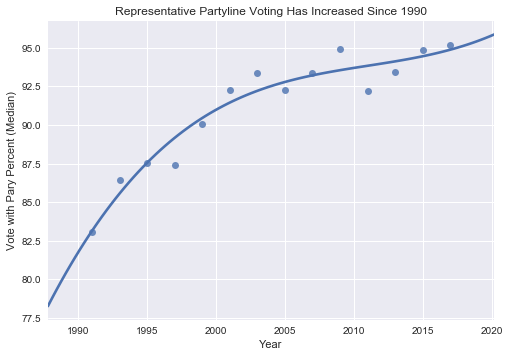

In [263]:
ax = sns.regplot(x='Year', y = '50%', data=df_full, order = 3, ci = False)
ax.set(ylabel='Vote with Pary Percent (Median)', 
       title = 'Representative Partyline Voting Has Increased Since 1990')

In [266]:
95.2-83.04

12.159999999999997

In [265]:
df_full

,count,mean,std,min,25%,50%,75%,max,Year
115,440.0,93.896591,6.640148,0.00,93.8625,95.180,96.1425,98.68,2017
114,440.0,93.669000,4.175090,64.40,92.8350,94.855,95.9425,100.00,2015
113,450.0,91.065467,11.559117,0.00,91.2600,93.420,94.9475,97.83,2013
112,451.0,89.218891,12.215971,0.00,89.6800,92.220,93.6900,98.18,2011
111,452.0,94.190022,4.266860,70.99,92.3175,94.955,97.4500,100.00,2009
110,453.0,92.560044,4.809008,73.36,89.8800,93.370,96.6400,100.00,2007
109,446.0,90.156502,10.475921,0.00,89.2975,92.250,93.8975,100.00,2005
108,446.0,91.057152,12.165978,0.00,91.1200,93.350,94.9475,97.86,2003
107,448.0,89.940402,11.726145,0.00,88.6250,92.300,94.6300,98.48,2001
106,445.0,87.816787,10.859108,0.00,86.8500,90.060,92.2900,98.37,1999


In [226]:
members[['id','dw_nominate']]

,id,dw_nominate
0,A000014,NaN
1,A000022,NaN
2,A000103,NaN
3,A000109,NaN
4,A000121,NaN
5,A000189,NaN
6,A000211,NaN
7,A000210,NaN
8,A000209,NaN
9,A000212,NaN


In [209]:
import matplotlib.pyplot as pltt
%matplotlib inline

In [211]:
import seaborn as sns

,0,1
0,115,1.121076
1,114,13.839286
2,113,25.111111
3,112,40.354767
4,111,52.876106
5,110,59.161148
6,109,65.246637
7,108,69.282511
8,107,74.107143
9,106,77.078652


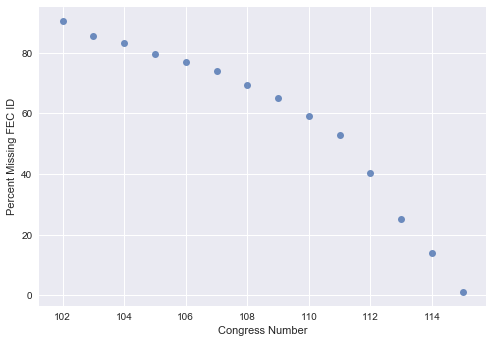

In [223]:
ax = sns.regplot(data=pd.DataFrame(count_missing, columns=['0','1']), 
            x='0', y = '1', ci = False, fit_reg = False)
ax.set(xlabel='Congress Number', ylabel='Percent Missing FEC ID')

In [224]:
members.columns

Index(['api_uri', 'at_large', 'contact_form', 'crp_id', 'cspan_id',
       'date_of_birth', 'district', 'dw_nominate', 'facebook_account', 'fax',
       'fec_candidate_id', 'first_name', 'geoid', 'google_entity_id',
       'govtrack_id', 'icpsr_id', 'id', 'ideal_point', 'in_office',
       'last_name', 'leadership_role', 'middle_name', 'missed_votes',
       'missed_votes_pct', 'ocd_id', 'office', 'party', 'phone', 'rss_url',
       'seniority', 'short_title', 'state', 'title', 'total_present',
       'total_votes', 'twitter_account', 'url', 'votes_with_party_pct',
       'votesmart_id', 'youtube_account'],
      dtype='object')

TypeError: 'str' object is not callable

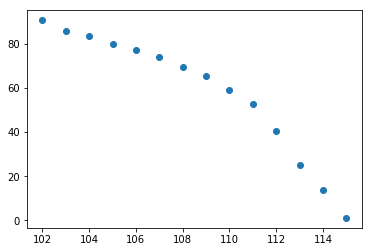

In [210]:
pltt.scatter(x = [x[0] for x in count_missing], y = [x[1] for x in count_missing])
pltt.ylabel("Percent Missing FEC ID")
pltt.xlabel("Congress Number")


In [182]:
file

'house102'

In [167]:
test = co_matrix(df_current, current_members)

In [173]:
test.isnull().sum().sum()

0

In [161]:
pd.DataFrame(np.zeros((len(current_members), 2)), index = list(current_members))

,0,1
C001049,0.0,0.0
L000585,0.0,0.0
L000564,0.0,0.0
S001168,0.0,0.0
B001291,0.0,0.0
B001270,0.0,0.0
G000568,0.0,0.0
S001191,0.0,0.0
B001295,0.0,0.0
K000390,0.0,0.0


In [158]:
list(current_members)

['C001049',
 'L000585',
 'L000564',
 'S001168',
 'B001291',
 'B001270',
 'G000568',
 'S001191',
 'B001295',
 'K000390',
 'J000299',
 'C000714',
 'D000482',
 'J000288',
 'S001195',
 'L000576',
 'T000472',
 'W000822',
 'R000435',
 'Z000017',
 'K000188',
 'C001091',
 'N000127',
 'S001185',
 'P000597',
 'V000132',
 'B001275',
 'G000577',
 'B001305',
 'B001227',
 'B001301',
 'N000188',
 'L000491',
 'D000617',
 'C001084',
 'C001108',
 'S001157',
 'K000388',
 'D000614',
 'D000598',
 'W000809',
 'C001053',
 'M001177',
 'D000191',
 'K000382',
 'G000566',
 'S001183',
 'C001112',
 'C001066',
 'K000380',
 'K000385',
 'P000598',
 'S001145',
 'G000535',
 'R000599',
 'A000370',
 'H000874',
 'C001107',
 'R000609',
 'C001059',
 'F000465',
 'W000800',
 'D000533',
 'F000372',
 'B001257',
 'N000015',
 'B001300',
 'B001269',
 'R000395',
 'A000369',
 'F000464',
 'D000627',
 'H001065',
 'B001296',
 'S000583',
 'E000215',
 'P000523',
 'L000573',
 'F000448',
 'M001166',
 'L000567',
 'G000581',
 'K000389',
 'S0

In [150]:
test.shape

(157, 157)

In [132]:
df_current.shape

(12, 28)

In [154]:
len(set(test.index))

157

In [128]:
industry

'ind_Civil Servants/Public Officials'

In [102]:
df_current = co_matrix(df_current)
df_current = SVD(df_current, d = d)
df_cs = pd.DataFrame(cosine_similarity(df_current), 
                     index=df_current.index, 
                     columns=df_current.index)

C:\Users\Steve\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)
C:\Users\Steve\Anaconda3\lib\site-packages\ipykernel\__main__.py:51: RuntimeWarning: divide by zero encountered in log


In [106]:
df_cs = df_cs.unstack().to_dict()

{('N00000270', 'N00000270'): 1.0000000000000002,
 ('N00000270', 'N00000362'): 0.96915220793531365,
 ('N00000270', 'N00000491'): 0.71601910714998529,
 ('N00000270', 'N00000528'): 0.88947951937408576,
 ('N00000270', 'N00000699'): 0.95624790351306854,
 ('N00000270', 'N00001093'): 0.89967262393969794,
 ('N00000270', 'N00001489'): 0.40396930554196692,
 ('N00000270', 'N00001758'): 0.61679095248382576,
 ('N00000270', 'N00001955'): 0.94613749712923434,
 ('N00000270', 'N00002097'): 0.91082060999580128,
 ('N00000270', 'N00002221'): 0.42193465856805001,
 ('N00000270', 'N00002593'): 0.57476999218125524,
 ('N00000270', 'N00003280'): 0.45930951221024091,
 ('N00000270', 'N00003328'): 0.57644979543308428,
 ('N00000270', 'N00003389'): 0.51287695648826526,
 ('N00000270', 'N00003535'): 0.9685130663225836,
 ('N00000270', 'N00003682'): 0.4300819909887571,
 ('N00000270', 'N00004118'): 0.94796671820782619,
 ('N00000270', 'N00004367'): 0.97051984753344089,
 ('N00000270', 'N00004572'): 0.53810410204336101,
 ('

In [100]:
df_current.head()

,Cycle,FECRecNo,PACID,CID,Amount,Date,RealCode,Type,DI,FECCandID,FirstLastP,Party,DistIDRunFor,DistIDCurr,CurrCand,CycleCand,CRPICO,RecipCode,NoPacs,PACShort,Affiliate,Ultorg,PrimCode,Source,Sensitive,Foreign,Active,CandidateCommittee
61,1990,3062020110012422130,C00140061,N00000362,1000.0,08/24/1990,H1100,24K,D,H0RI02071,Jack Reed (D),D,RI02,,Y,Y,O,DW,,American College of Emergency Physicians,NaN,American College of Emergency Physicians,H1100,AFP88,N,0.0,1.0,False
63,1990,3062020110011285503,C00002501,N00001955,2500.0,11/06/1989,H1100,24K,D,H6MD03177,Ben Cardin (D),D,MD03,MD03,Y,Y,I,DW,,Maryland Medical Assn,American Medical Assn,American Medical Assn,H1100,AFP88,N,0.0,1.0,False
68,1990,3062020110012739547,C00085910,N00003389,1000.0,04/03/1989,A4100,24K,D,S2KY00012,Mitch McConnell (R),R,KYS1,KYS1,Y,Y,I,RW,,Fertilizer Institute,NaN,Fertilizer Institute,A4100,NTPA,N,0.0,1.0,False
69,1990,3062020110012011307,C00185124,N00001093,500.0,09/26/1990,C4200,24K,D,H0NY16010,Charles E Schumer (D),D,NY10,NY10,Y,Y,I,DW,,AT&T,NaN,AT&T,C4200,AnRpt90,Y,0.0,1.0,False
132,1990,3062020110009795742,C00066472,N00001955,350.0,10/10/1989,F3100,24K,D,H6MD03177,Ben Cardin (D),D,MD03,MD03,Y,Y,I,DW,,National Assn of Independent Insurers,NaN,National Assn of Independent Insurers,F3100,AFP88,Y,0.0,1.0,False


In [98]:
100/435

0.22988505747126436

In [96]:
body = 'senate'

In [94]:
sects_inds.index.tolist() + ['All']

['ind_Abortion Policy/Anti-Abortion',
 'ind_Abortion Policy/Pro-Abortion Rights',
 'ind_Accountants',
 'ind_Agricultural Services/Products',
 'ind_Air Transport',
 'ind_Automotive',
 'ind_Beer, Wine & Liquor',
 'ind_Building Materials & Equipment',
 'ind_Building Trade Unions',
 'ind_Business Associations',
 'ind_Business Services',
 'ind_Candidate Committees',
 'ind_Candidate Self-finance',
 'ind_Casinos/Gambling',
 'ind_Chemical & Related Manufacturing',
 'ind_Civil Servants/Public Officials',
 'ind_Clergy & Religious Organizations',
 'ind_Commercial Banks',
 'ind_Construction Services',
 'ind_Credit Unions',
 'ind_Crop Production & Basic Processing',
 'ind_Dairy',
 'ind_Defense Aerospace',
 'ind_Defense Electronics',
 'ind_Democratic/Liberal',
 'ind_Education',
 'ind_Electric Utilities',
 'ind_Electronics Mfg & Equip',
 'ind_Employer Listed/Category Unknown',
 'ind_Environment',
 'ind_Environmental Svcs/Equipment',
 'ind_Finance/Credit Companies',
 'ind_Fisheries & Wildlife',
 'ind_

In [89]:
df_current.Cycle.unique()

array([1990, 1992, 1994, 1996, 1998, 2000, 2002, 2004, 2006, 2008, 2010,
       2012, 2014, 2016], dtype=int64)

In [65]:
1934 + 

2016

In [73]:

get_year(102)

[1991, 1992]

In [47]:
members = congress.members.fetch("{}/{}/members.json".format('115','senate'))

In [16]:
set(industries.index) & set(sectors.index)

{'Misc Business', 'Non-contribution', 'Other', 'Unknown'}

In [4]:
df_industries.head()

,Catcode,Catname,Catorder,Industry,Sector,Sector Long
0,A0000,Agriculture,A11,Misc Agriculture,Agribusiness,Agribusiness
1,A1000,Crop production & basic processing,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
2,A1100,Cotton,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
3,A1200,Sugar cane & sugar beets,A01,Crop Production & Basic Processing,Agribusiness,Agribusiness
4,A1300,Tobacco & Tobacco products,A02,Tobacco,Agribusiness,Agribusiness
